In [1]:
# packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from functools import reduce


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns

from typing import Tuple

import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.utils import resample
from scipy.stats import kendalltau
from statsmodels.stats.multitest import fdrcorrection


# local
from nb_util import autoreload, add_dirs
autoreload()

add_dirs(['../'])
from nash_util import concordance_stats as cs
from nash_util import nash_definitions as nd


In [2]:
def strict_con(row):
    rc = row.dropna()
    nrc = len(rc)
    if nrc == 3:
        return np.median(rc)
    elif nrc == 2:
        if rc[0] == rc[1]:
            return rc[0]
        else:
            return None
    else:
        return None

In [5]:
# load Cougar network path data
file = 'REFDATA/COUGAR_NP_V02.xlsx'
c_dfs = {}

c_dfs['Fibrosis'] = pd.read_excel(file, sheet_name='Fibrosis',engine='openpyxl')
c_dfs['Inflammation'] = pd.read_excel(file, sheet_name='Inflammation',engine='openpyxl')
c_dfs['Ballooning'] = pd.read_excel(file, sheet_name='Ballooning',engine='openpyxl')
c_dfs['Steatosis'] = pd.read_excel(file, sheet_name='Steatosis',engine='openpyxl')

# load Cougar continuous scores
cnash_tri = pd.read_excel('REFDATA/CONT_FEATURES/cougar_combined_features_tri.xlsx',sheet_name='FEATURE',engine='openpyxl')
cnash_he = pd.read_excel('REFDATA/CONT_FEATURES/cougar_combined_features_he.xlsx',sheet_name='FEATURE', engine='openpyxl')

In [6]:
c_dfs['Fibrosis'] = c_dfs['Fibrosis'].merge(cnash_tri,how='left',left_on='PATHAI_ID',right_on='Trichrome_ID')
c_dfs['Inflammation'] = c_dfs['Inflammation'].merge(cnash_he[['H & E_ID','GNN LOBULAR_CONTINUOUS_SCORE_HE','GNN LOBULAR_SCORE_HE']],how='left',left_on='PATHAI_ID',right_on='H & E_ID')
c_dfs['Ballooning'] = c_dfs['Ballooning'].merge(cnash_he[['H & E_ID','GNN BALLOONING_CONTINUOUS_SCORE_HE','GNN BALLOONING_SCORE_HE']],how='left',left_on='PATHAI_ID',right_on='H & E_ID')
c_dfs['Steatosis'] = c_dfs['Steatosis'].merge(cnash_he[['H & E_ID','GNN STEATOSIS_CONTINUOUS_SCORE_HE','GNN STEATOSIS_SCORE_HE']],how='left',left_on='PATHAI_ID',right_on='H & E_ID')

In [7]:
for df in c_dfs.values():
    df['NP Mean'] = df[['NP0','NP1','NP2']].apply(np.nanmean,axis=1)
    df['CON'] = df[['NP0','NP1','NP2']].apply(strict_con,axis=1)

In [8]:
for df in c_dfs.values():
    display(df.head(5))

,PATHAI_ID,AIM,NP0,NP1,NP2,CASE_ID,Trichrome_ID,GNN CRN_CONTINUOUS_SCORE_TRICHROME,GNN CRN_SCORE_TRICHROME,NP Mean,CON
0,199154,1,1,0.0,2.0,199154,199154,1.131790,1,1.000000,1.0
1,199135,3,3,3.0,3.0,199135,199135,3.470083,3,3.000000,3.0
2,198949,3,2,3.0,3.0,198949,198949,3.358227,3,2.666667,3.0
3,198947,1,1,0.0,2.0,198947,198947,1.225053,1,1.000000,1.0
4,198945,3,1,3.0,3.0,198945,198945,3.424451,3,2.333333,3.0


,PATHAI_ID,AIM,NP0,NP1,NP2,H & E_ID,GNN LOBULAR_CONTINUOUS_SCORE_HE,GNN LOBULAR_SCORE_HE,NP Mean,CON
0,199158,0,1,1.0,0.0,199158,0.519915,0,0.666667,1.0
1,199141,1,2,2.0,1.0,199141,1.815436,1,1.666667,2.0
2,198951,1,1,1.0,1.0,198951,1.314175,1,1.000000,1.0
3,198950,1,1,2.0,1.0,198950,1.310162,1,1.333333,1.0
4,198948,1,1,1.0,2.0,198948,1.328157,1,1.333333,1.0


,PATHAI_ID,AIM,NP0,NP1,NP2,H & E_ID,GNN BALLOONING_CONTINUOUS_SCORE_HE,GNN BALLOONING_SCORE_HE,NP Mean,CON
0,199158,0,0,0.0,0.0,199158,0.567411,0,0.000000,0.0
1,199141,2,2,2.0,2.0,199141,2.286202,2,2.000000,2.0
2,198951,0,0,1.0,1.0,198951,0.850111,0,0.666667,1.0
3,198950,2,2,2.0,2.0,198950,2.104704,2,2.000000,2.0
4,198948,1,2,1.0,1.0,198948,1.689602,1,1.333333,1.0


,PATHAI_ID,AIM,NP0,NP1,NP2,H & E_ID,GNN STEATOSIS_CONTINUOUS_SCORE_HE,GNN STEATOSIS_SCORE_HE,NP Mean,CON
0,199158,0,1,0.0,1.0,199158,0.527157,0,0.666667,1.0
1,199141,3,3,3.0,3.0,199141,3.838455,3,3.000000,3.0
2,198951,2,1,2.0,2.0,198951,2.209968,2,1.666667,2.0
3,198950,3,2,3.0,2.0,198950,3.374045,3,2.333333,2.0
4,198948,0,0,1.0,1.0,198948,0.166618,0,0.666667,1.0


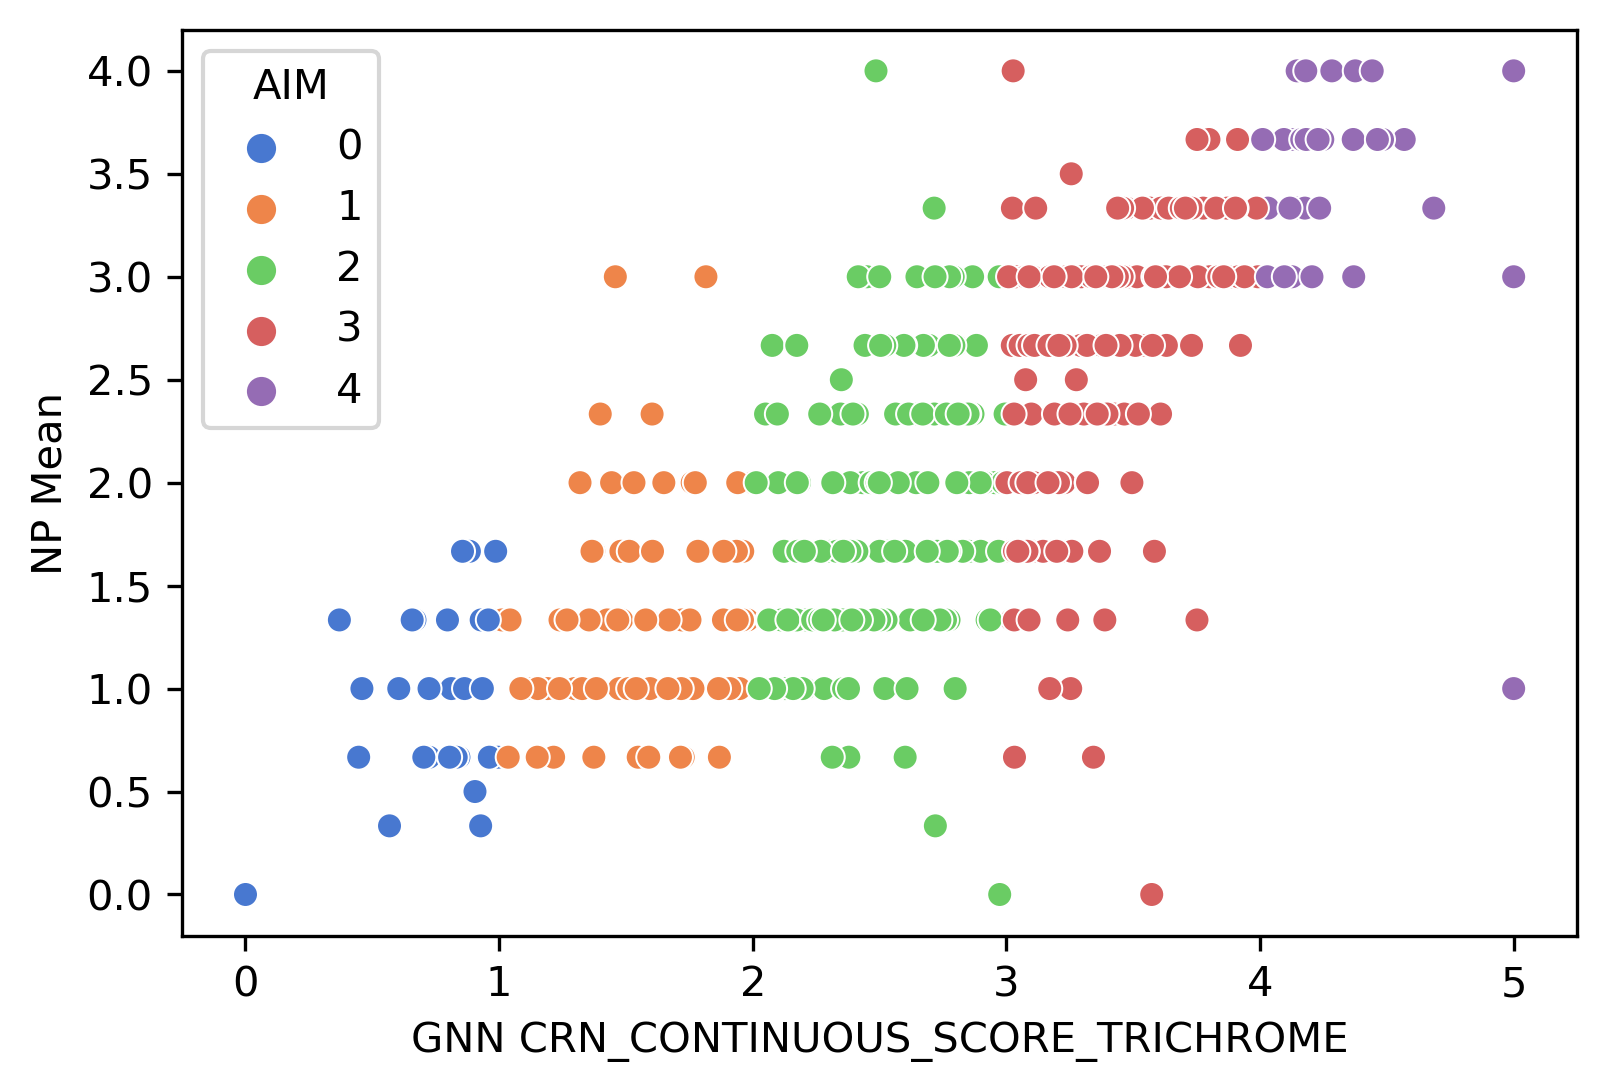

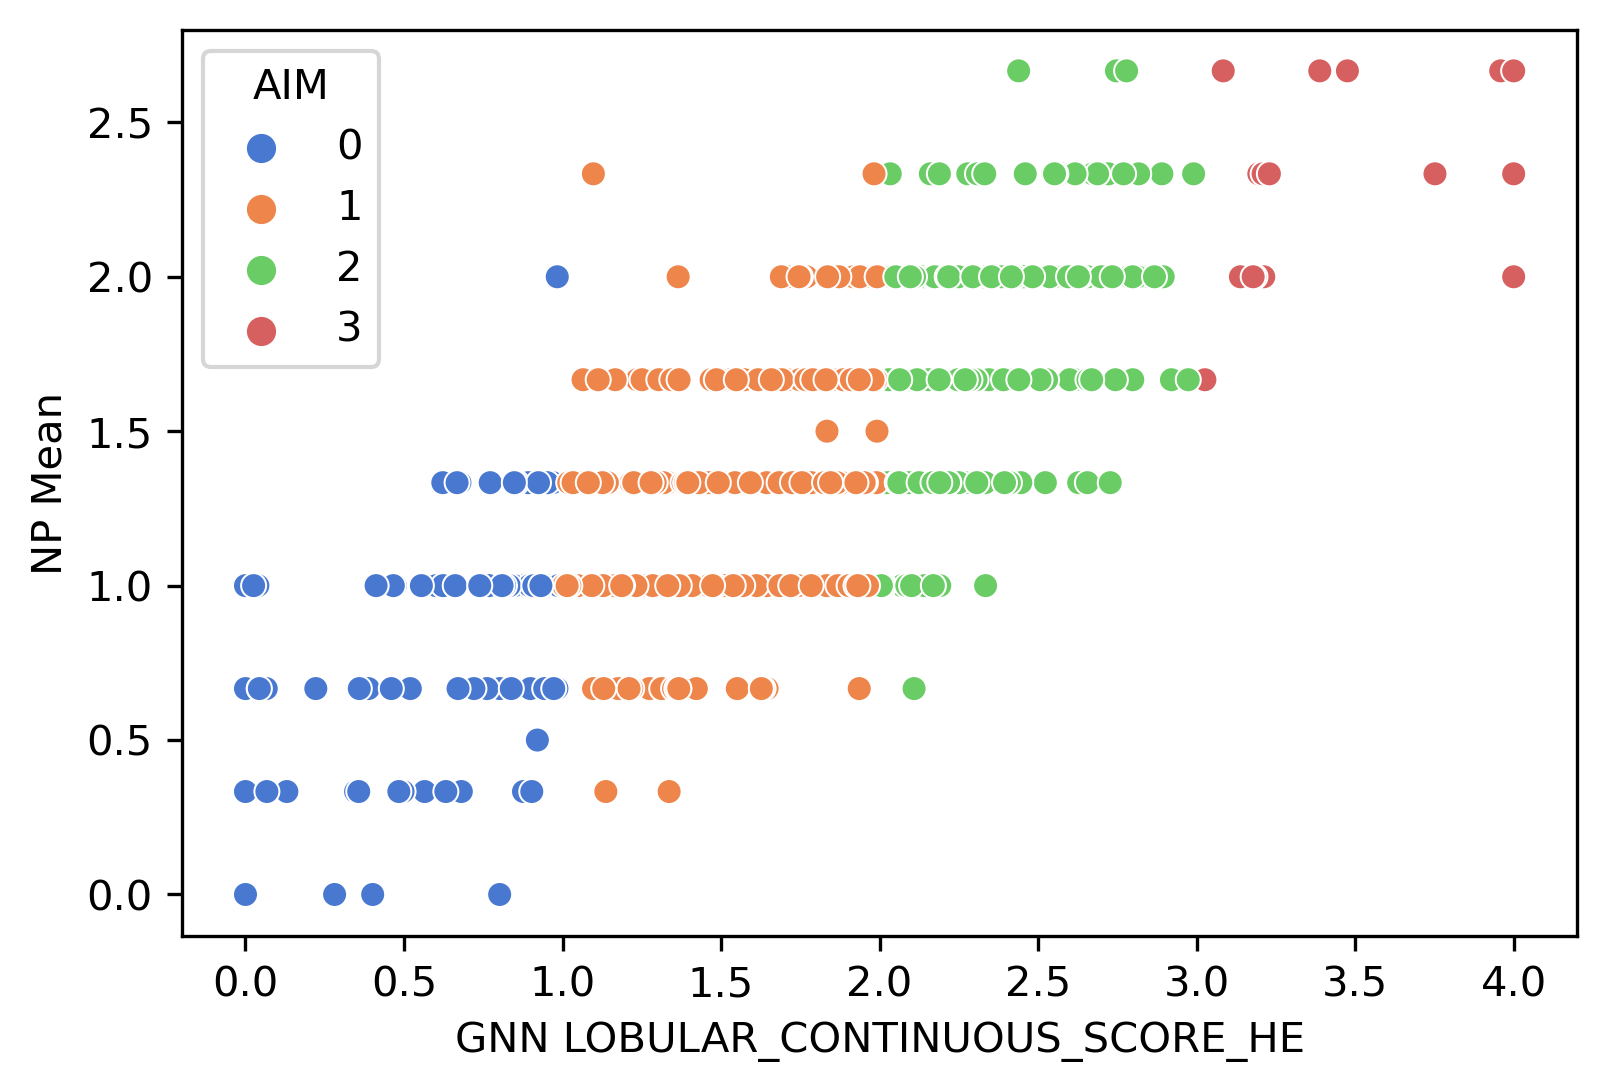

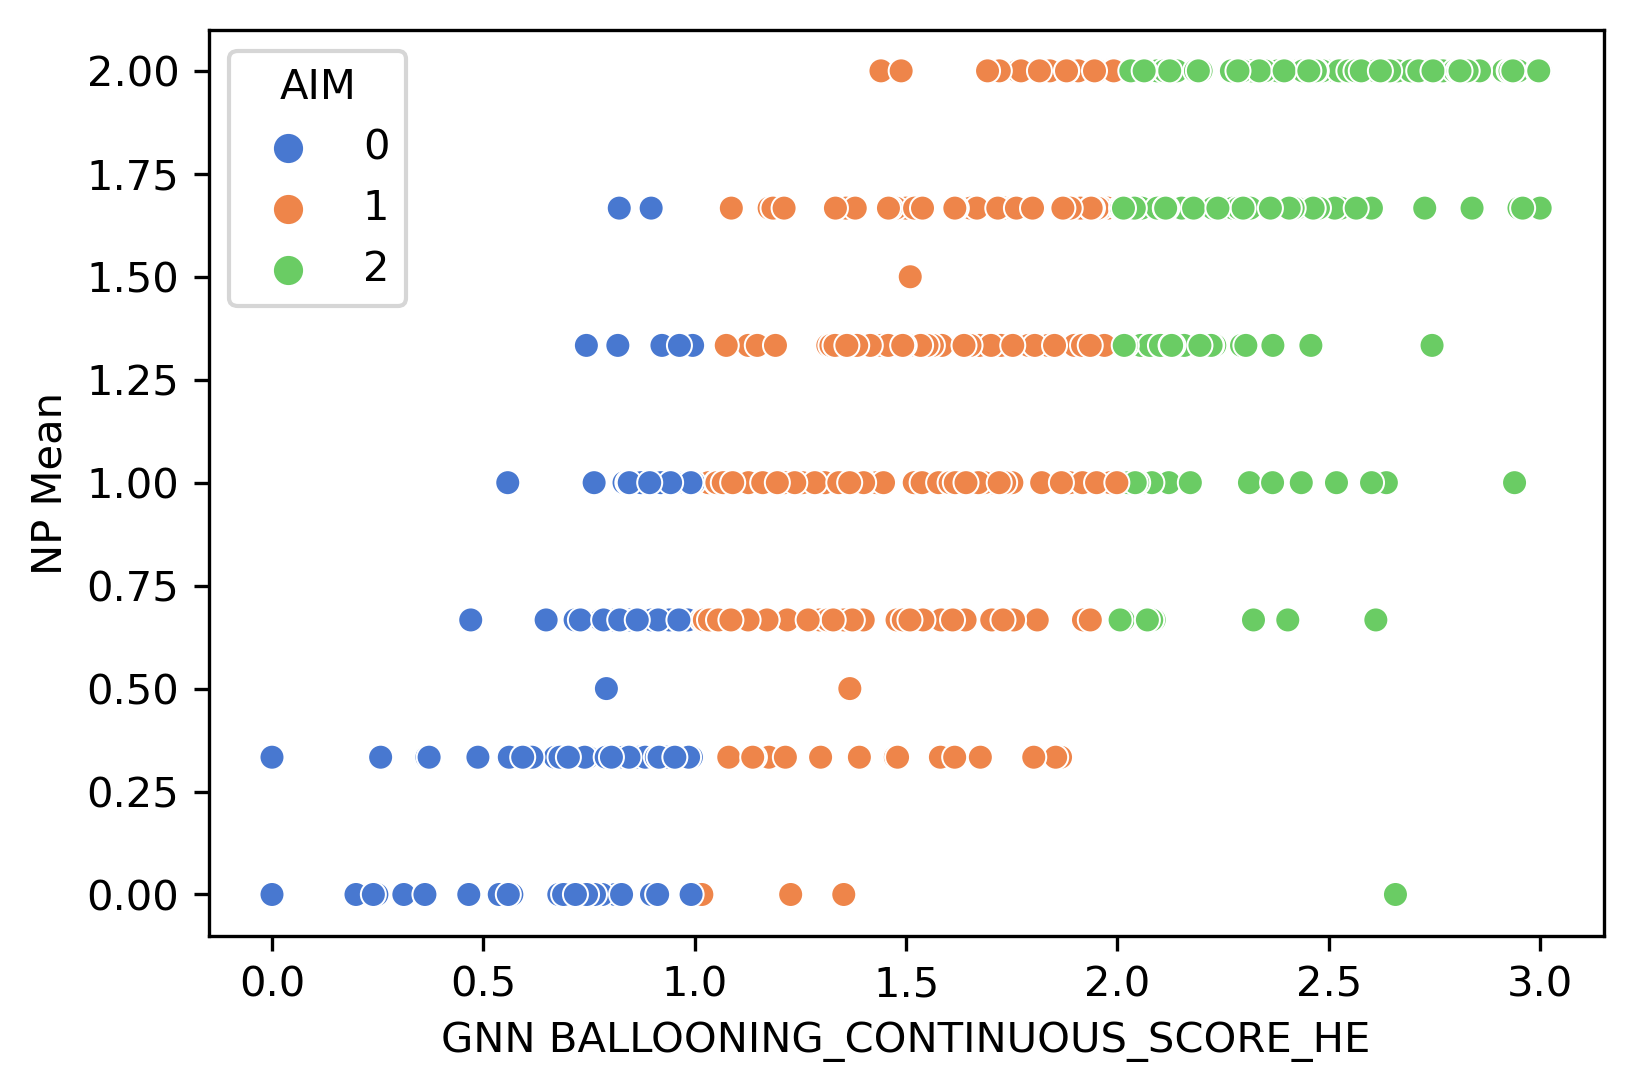

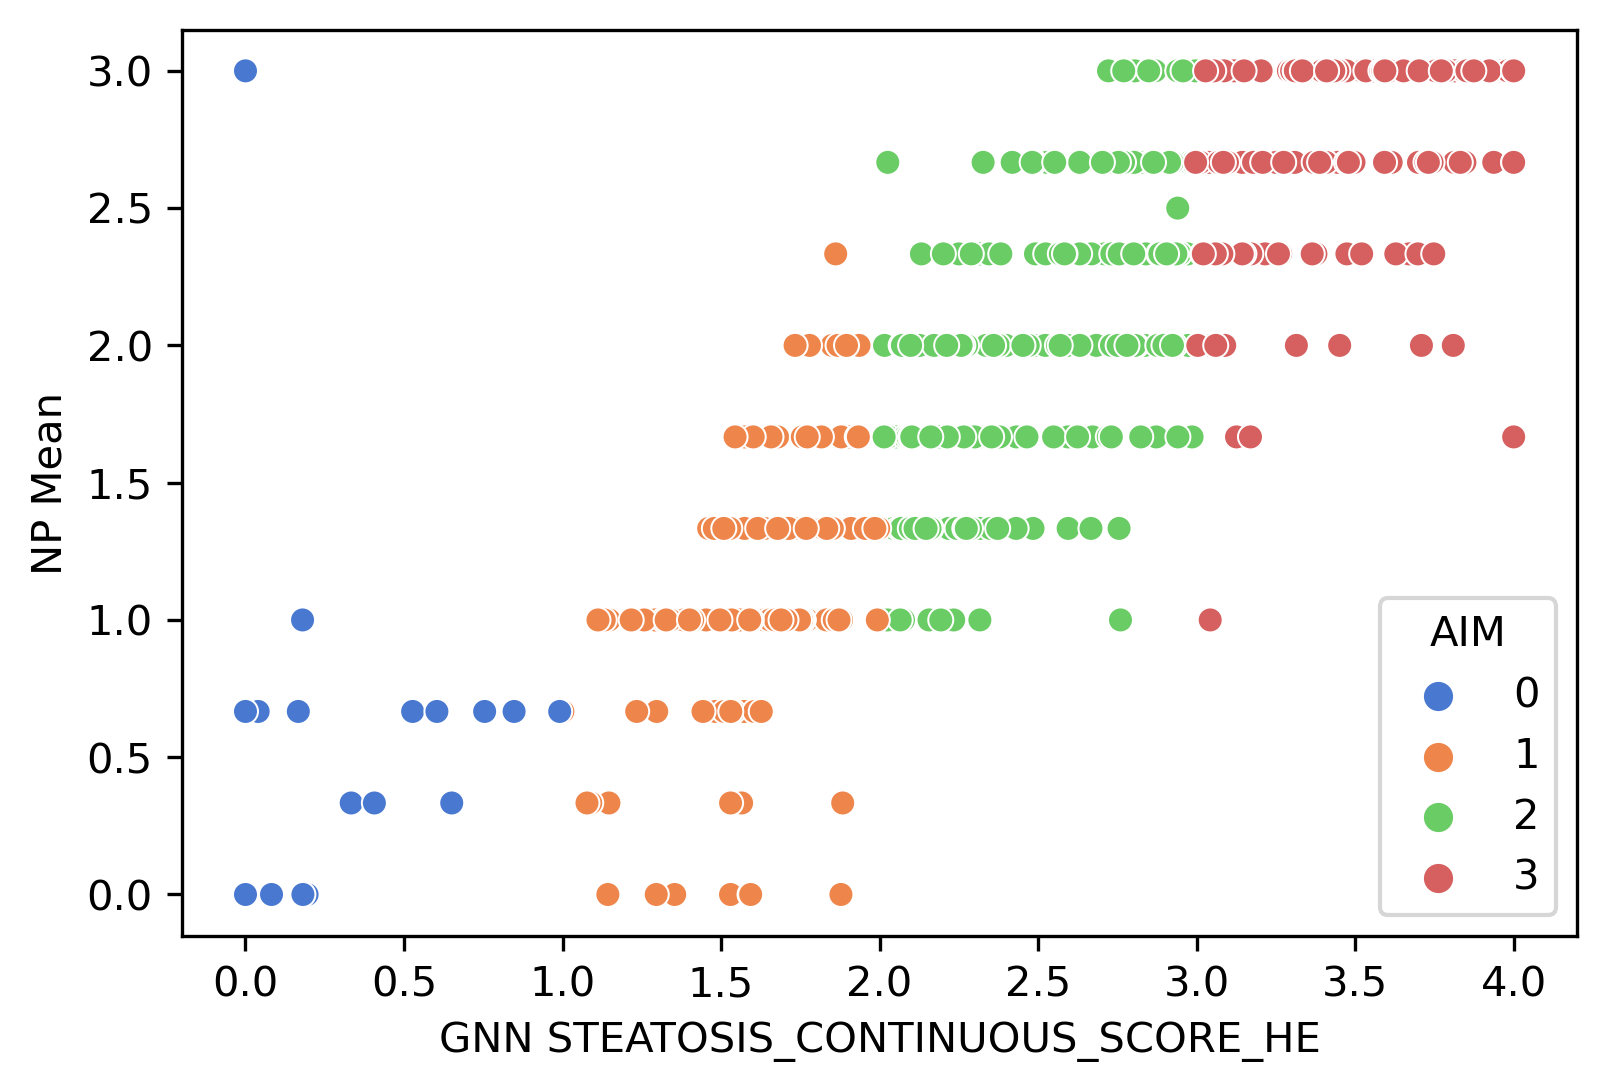

In [9]:
md = {
    'Fibrosis':'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'Inflammation':'GNN LOBULAR_CONTINUOUS_SCORE_HE',
    'Ballooning':'GNN BALLOONING_CONTINUOUS_SCORE_HE',
    'Steatosis':'GNN STEATOSIS_CONTINUOUS_SCORE_HE'
}
for hif, df in c_dfs.items():
    sns.scatterplot(data=df,y='NP Mean',x=md[hif],hue='AIM',palette='muted')
    plt.show()

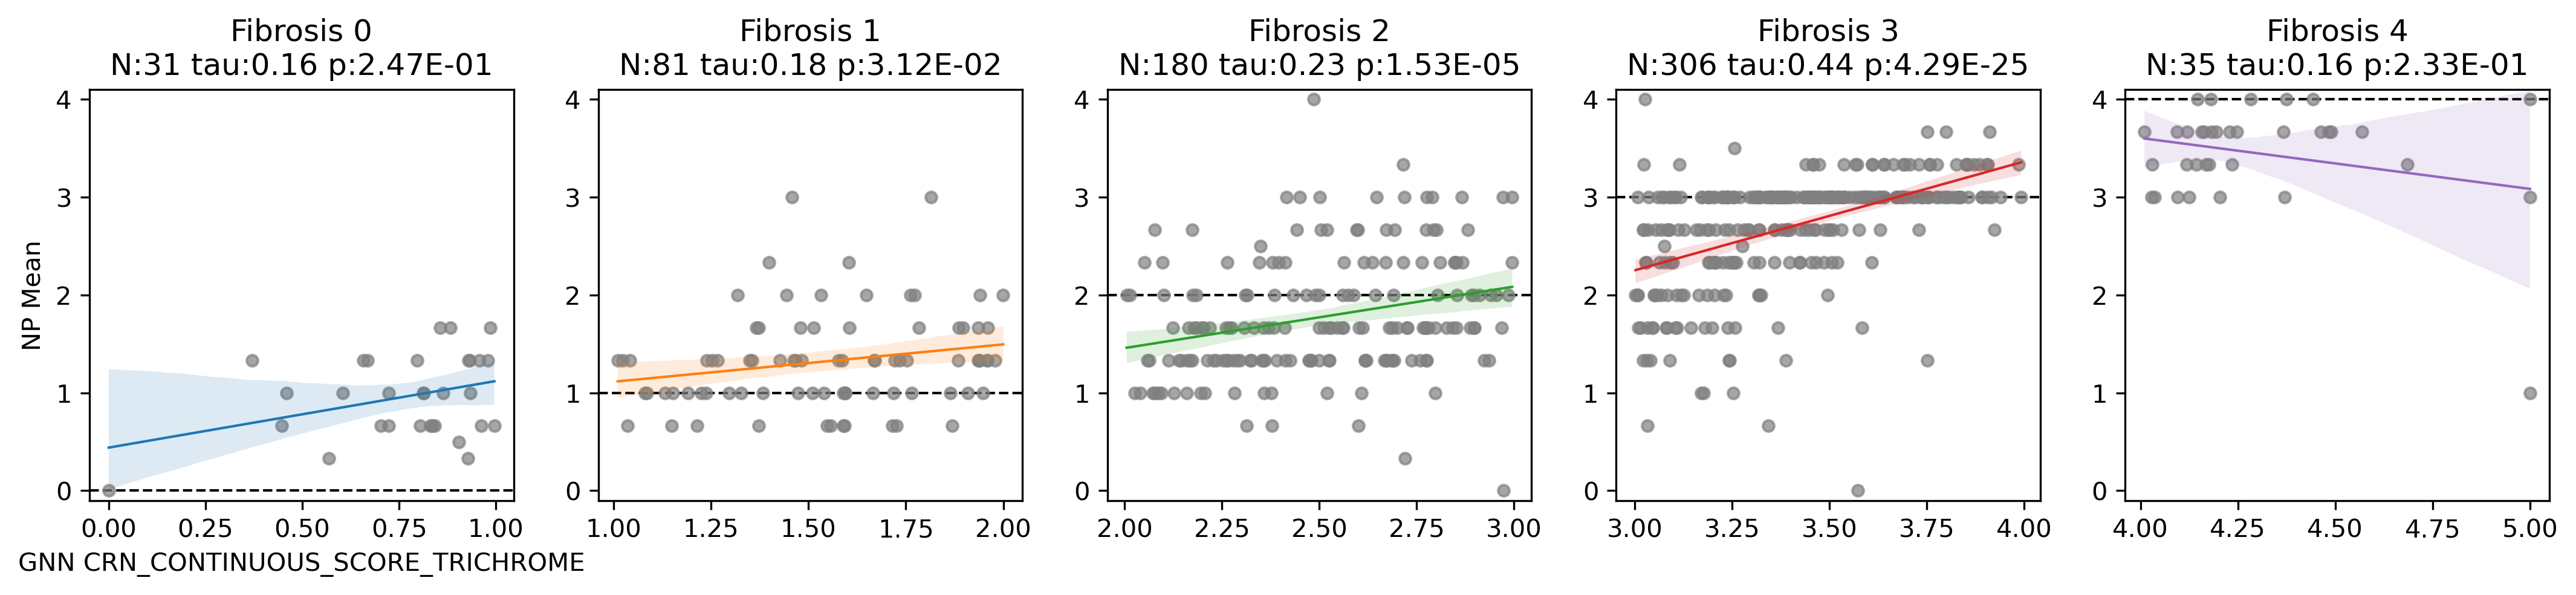

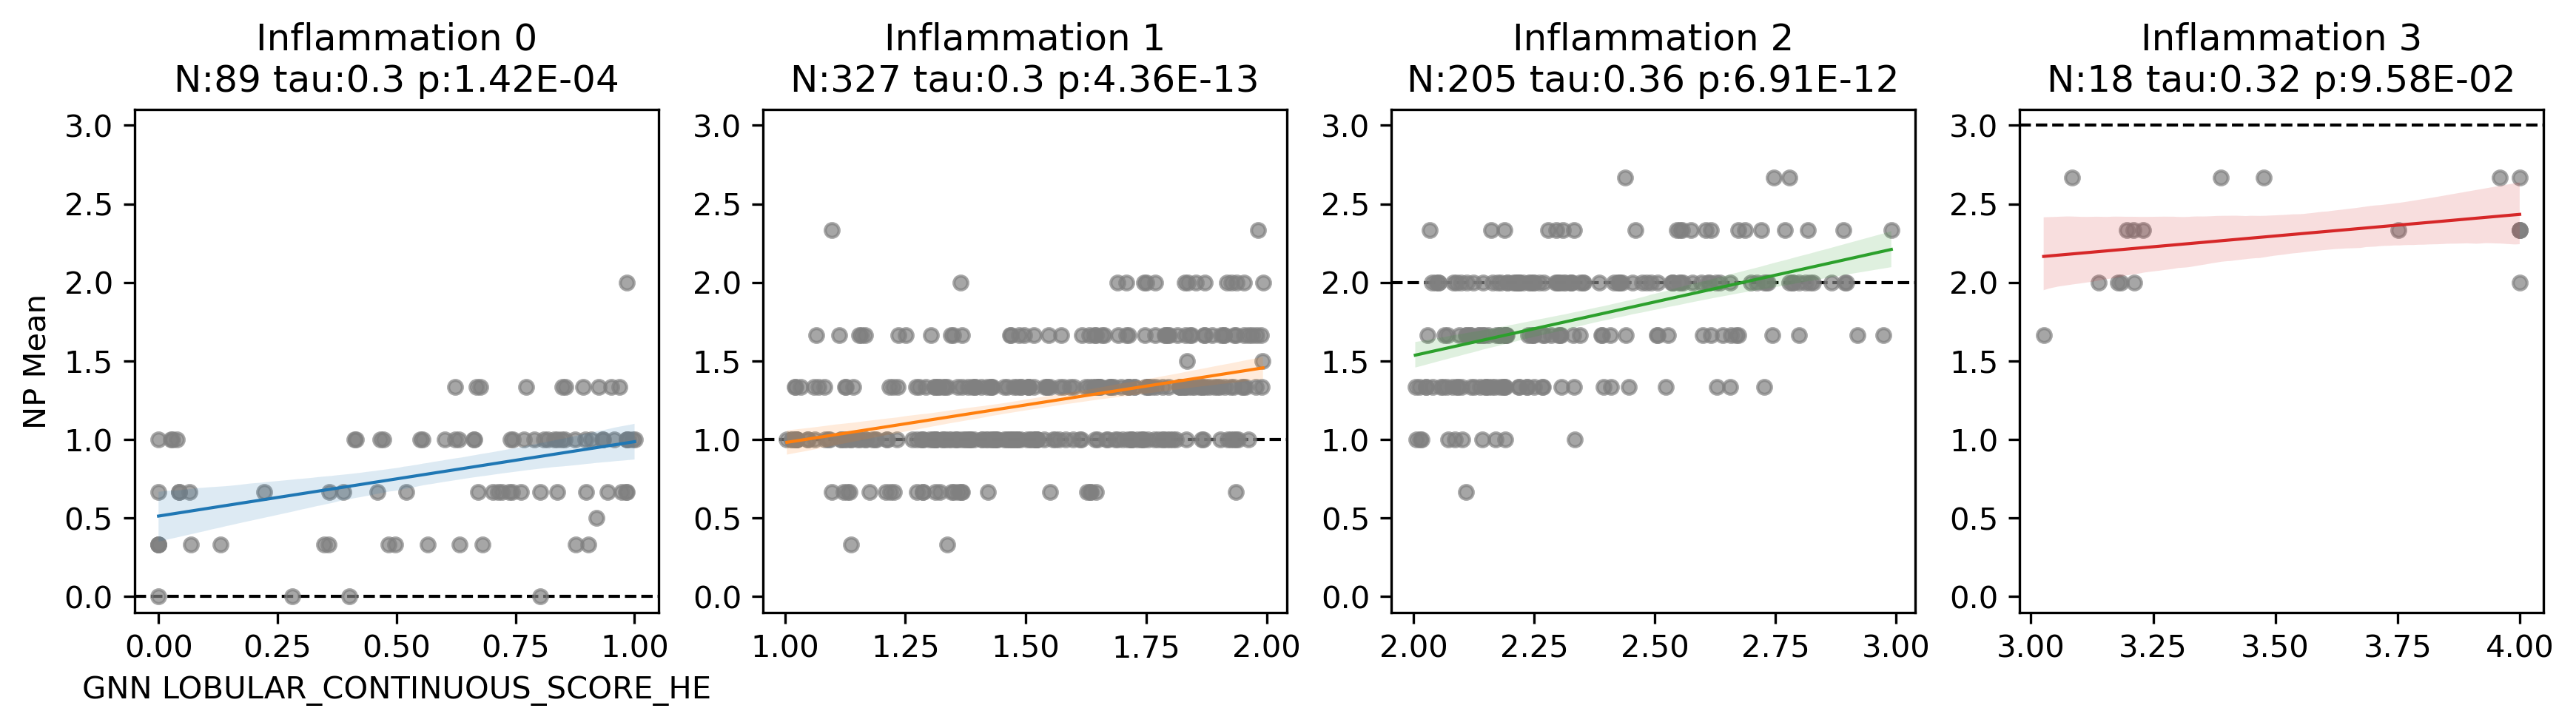

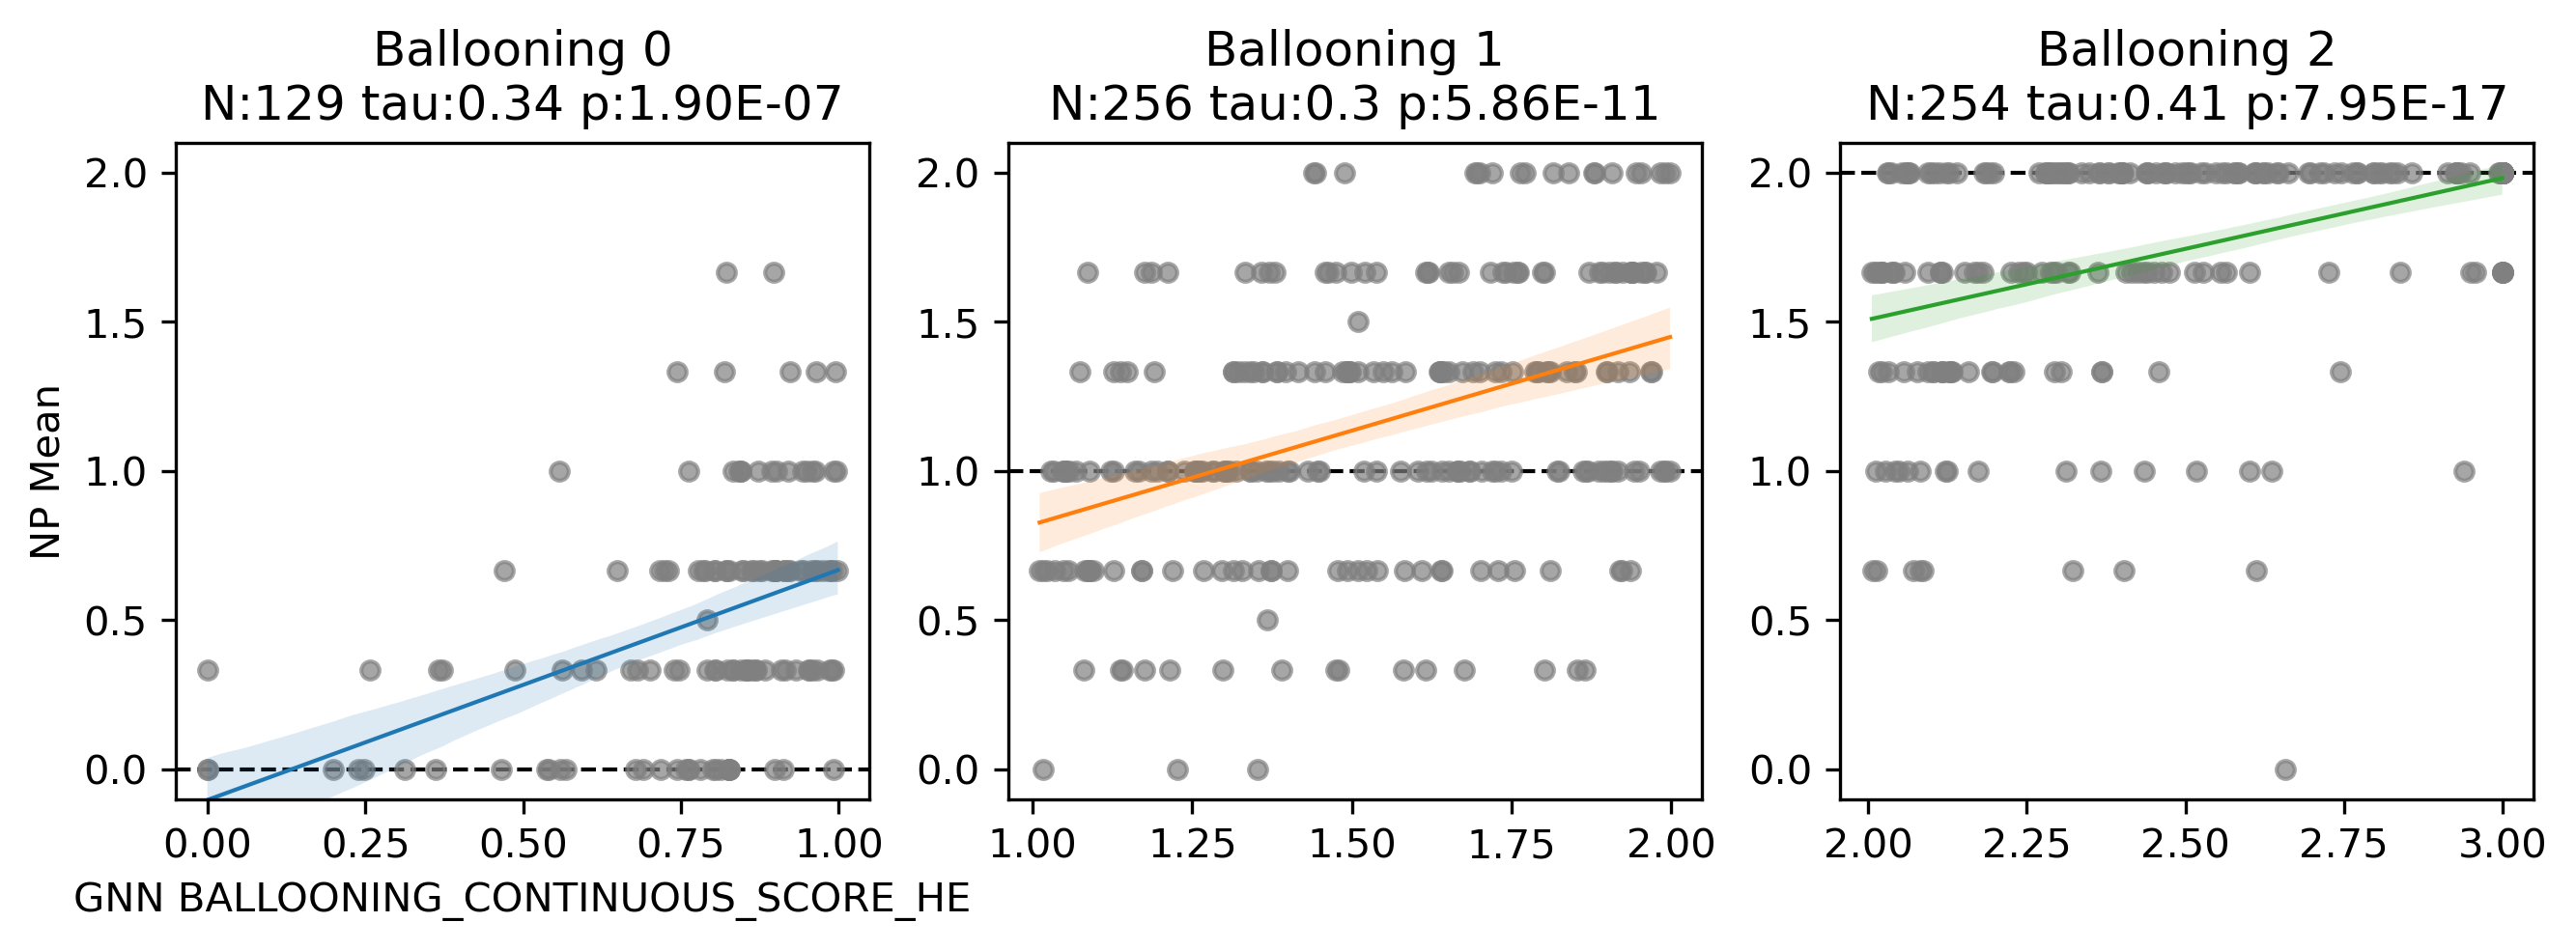

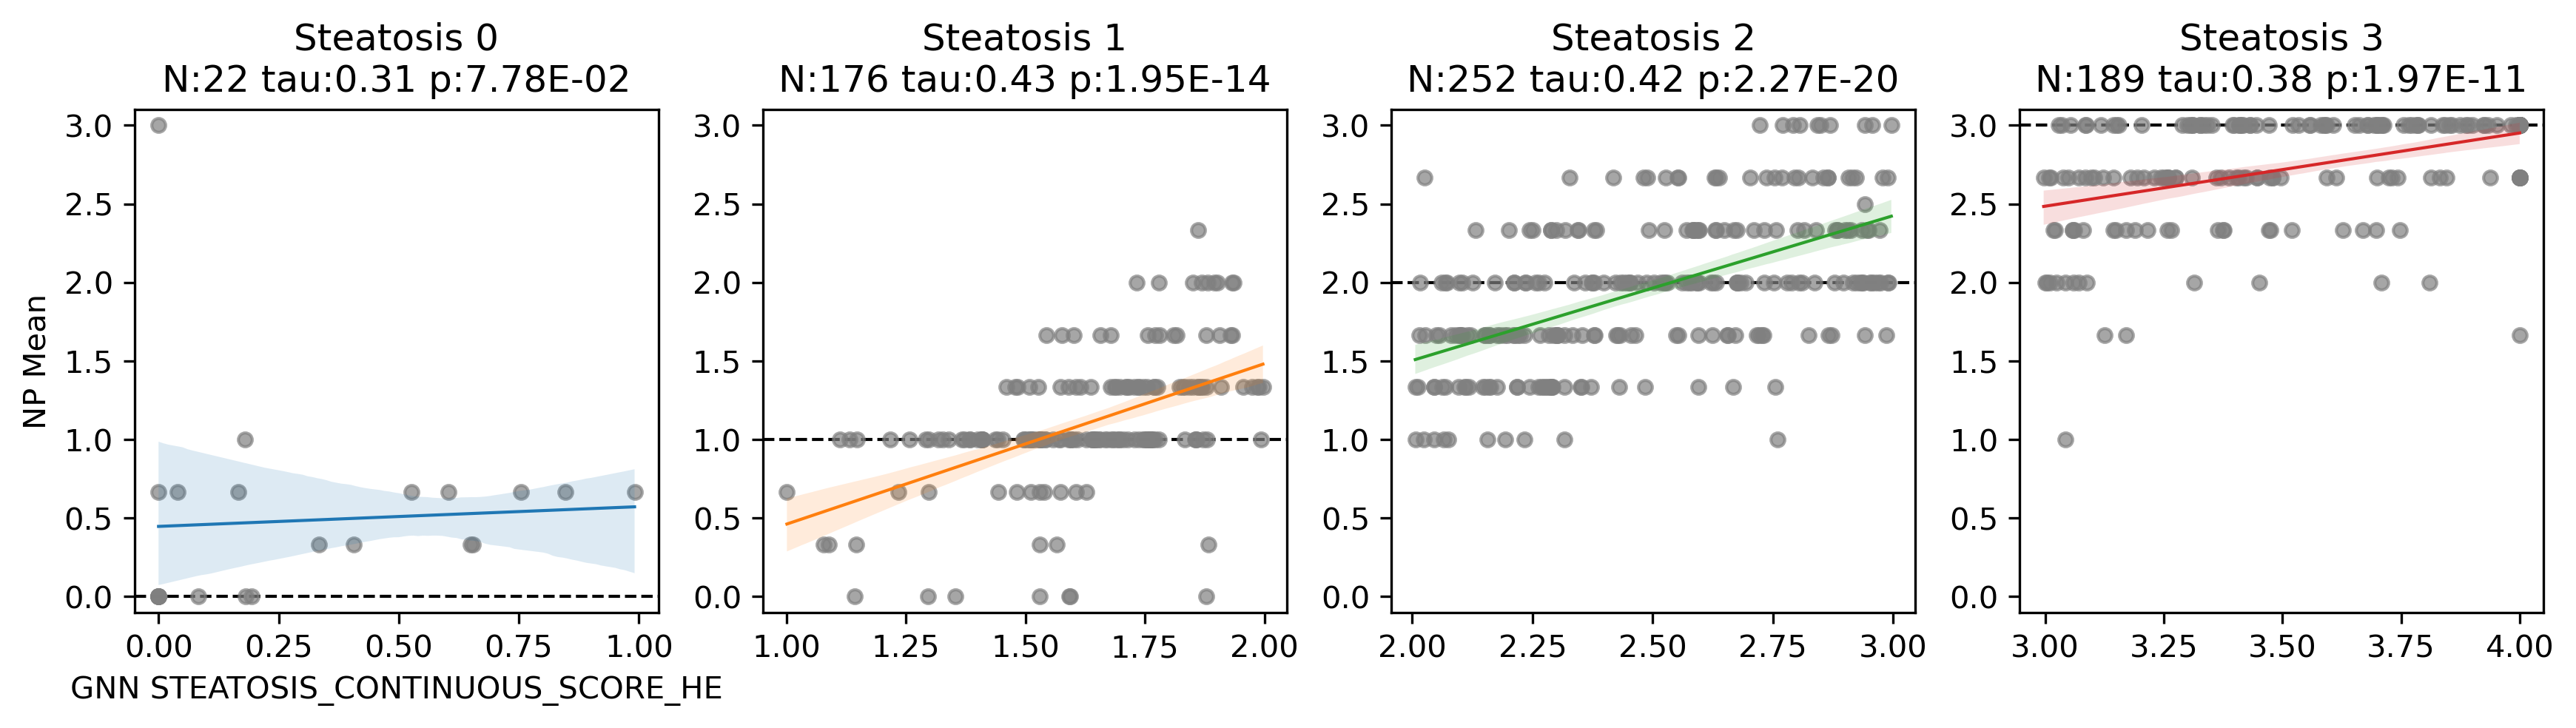

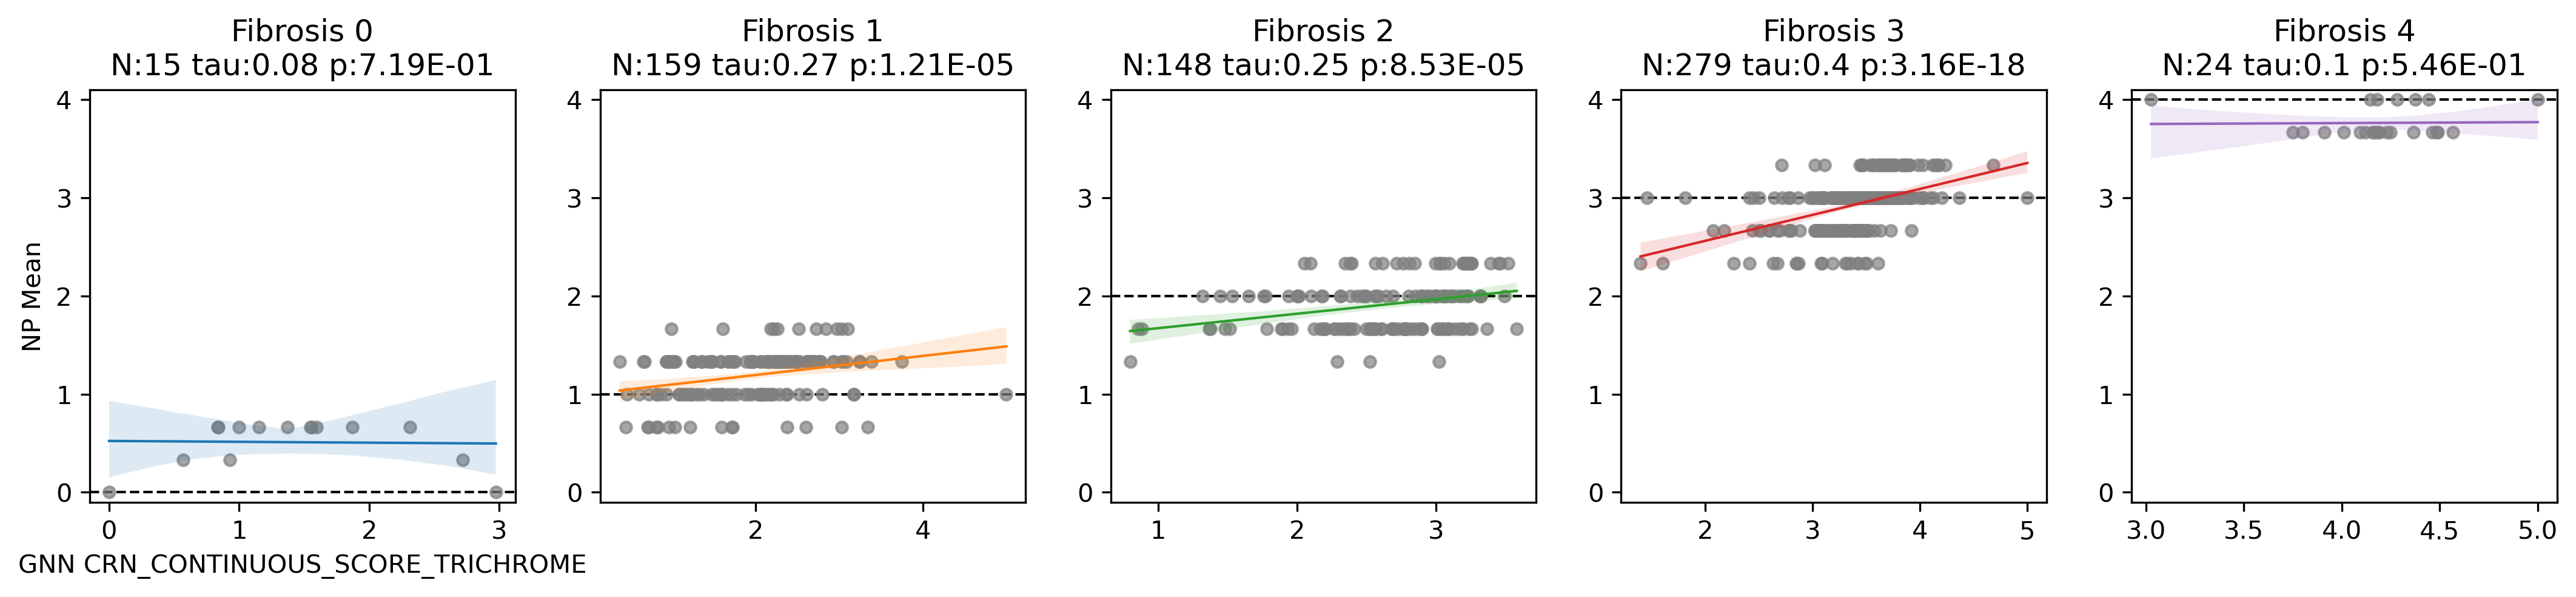

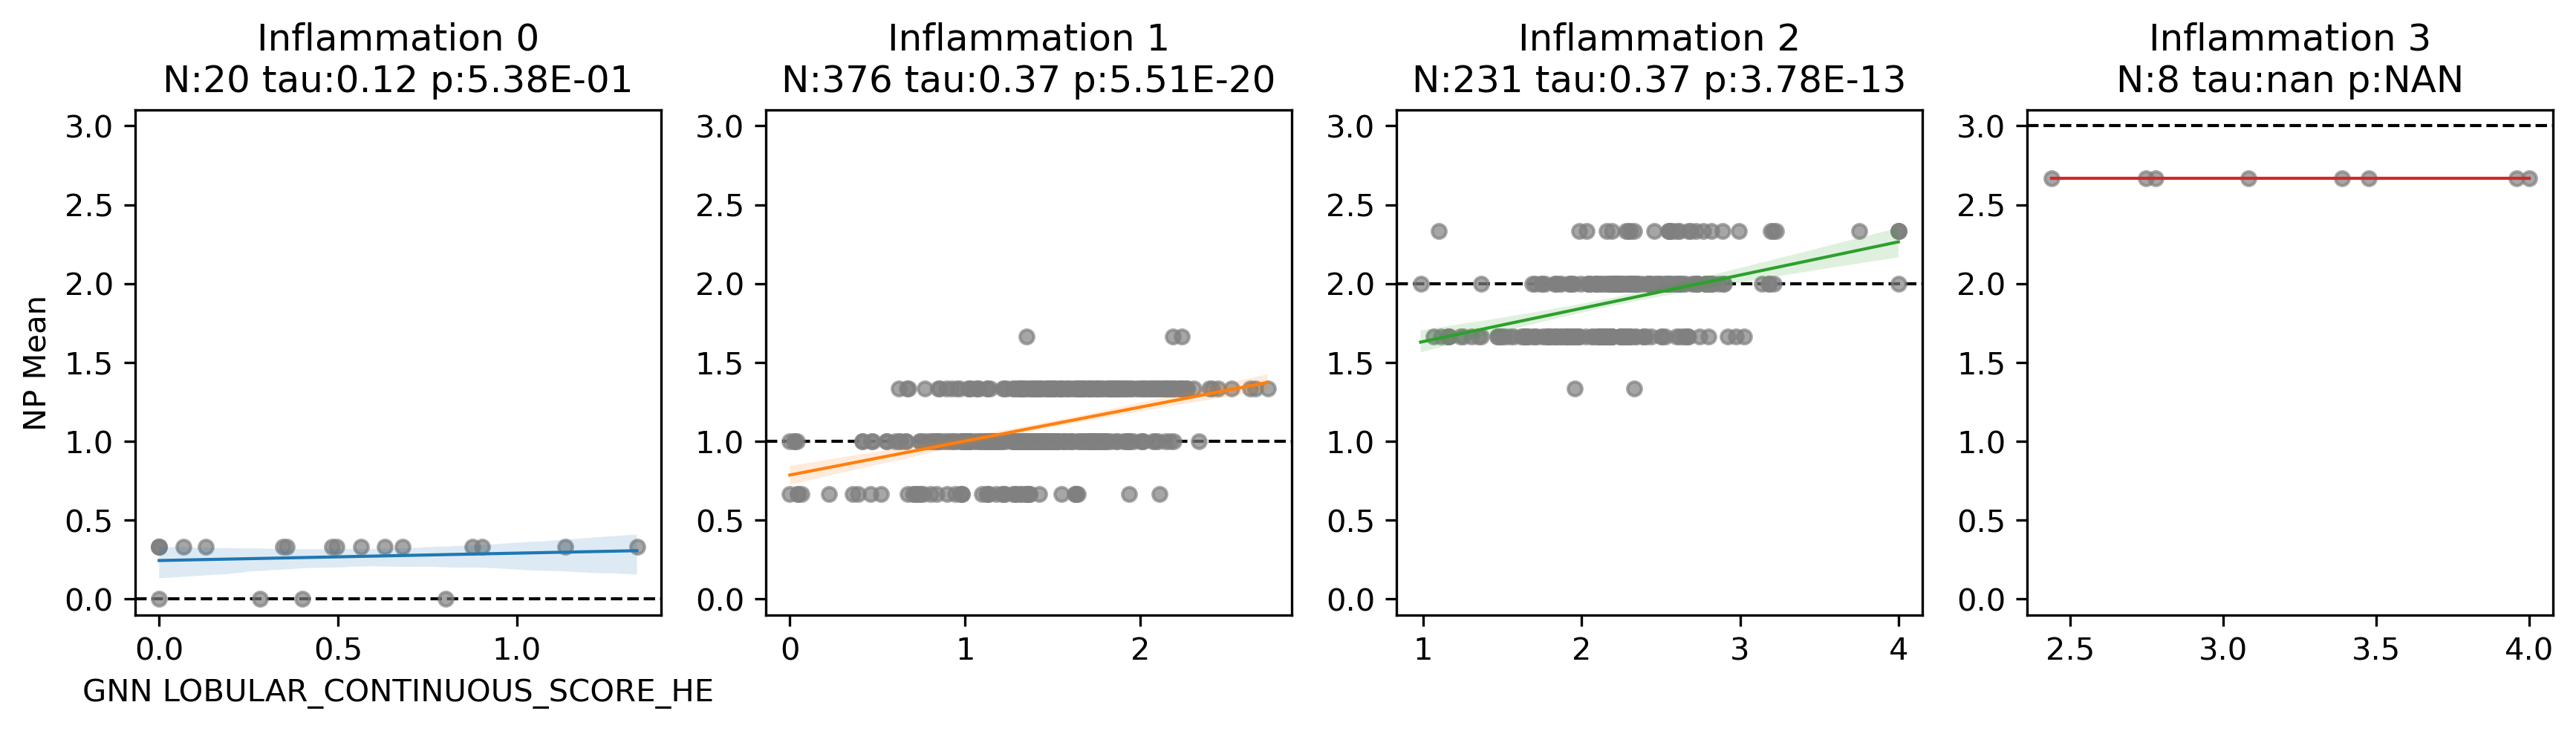

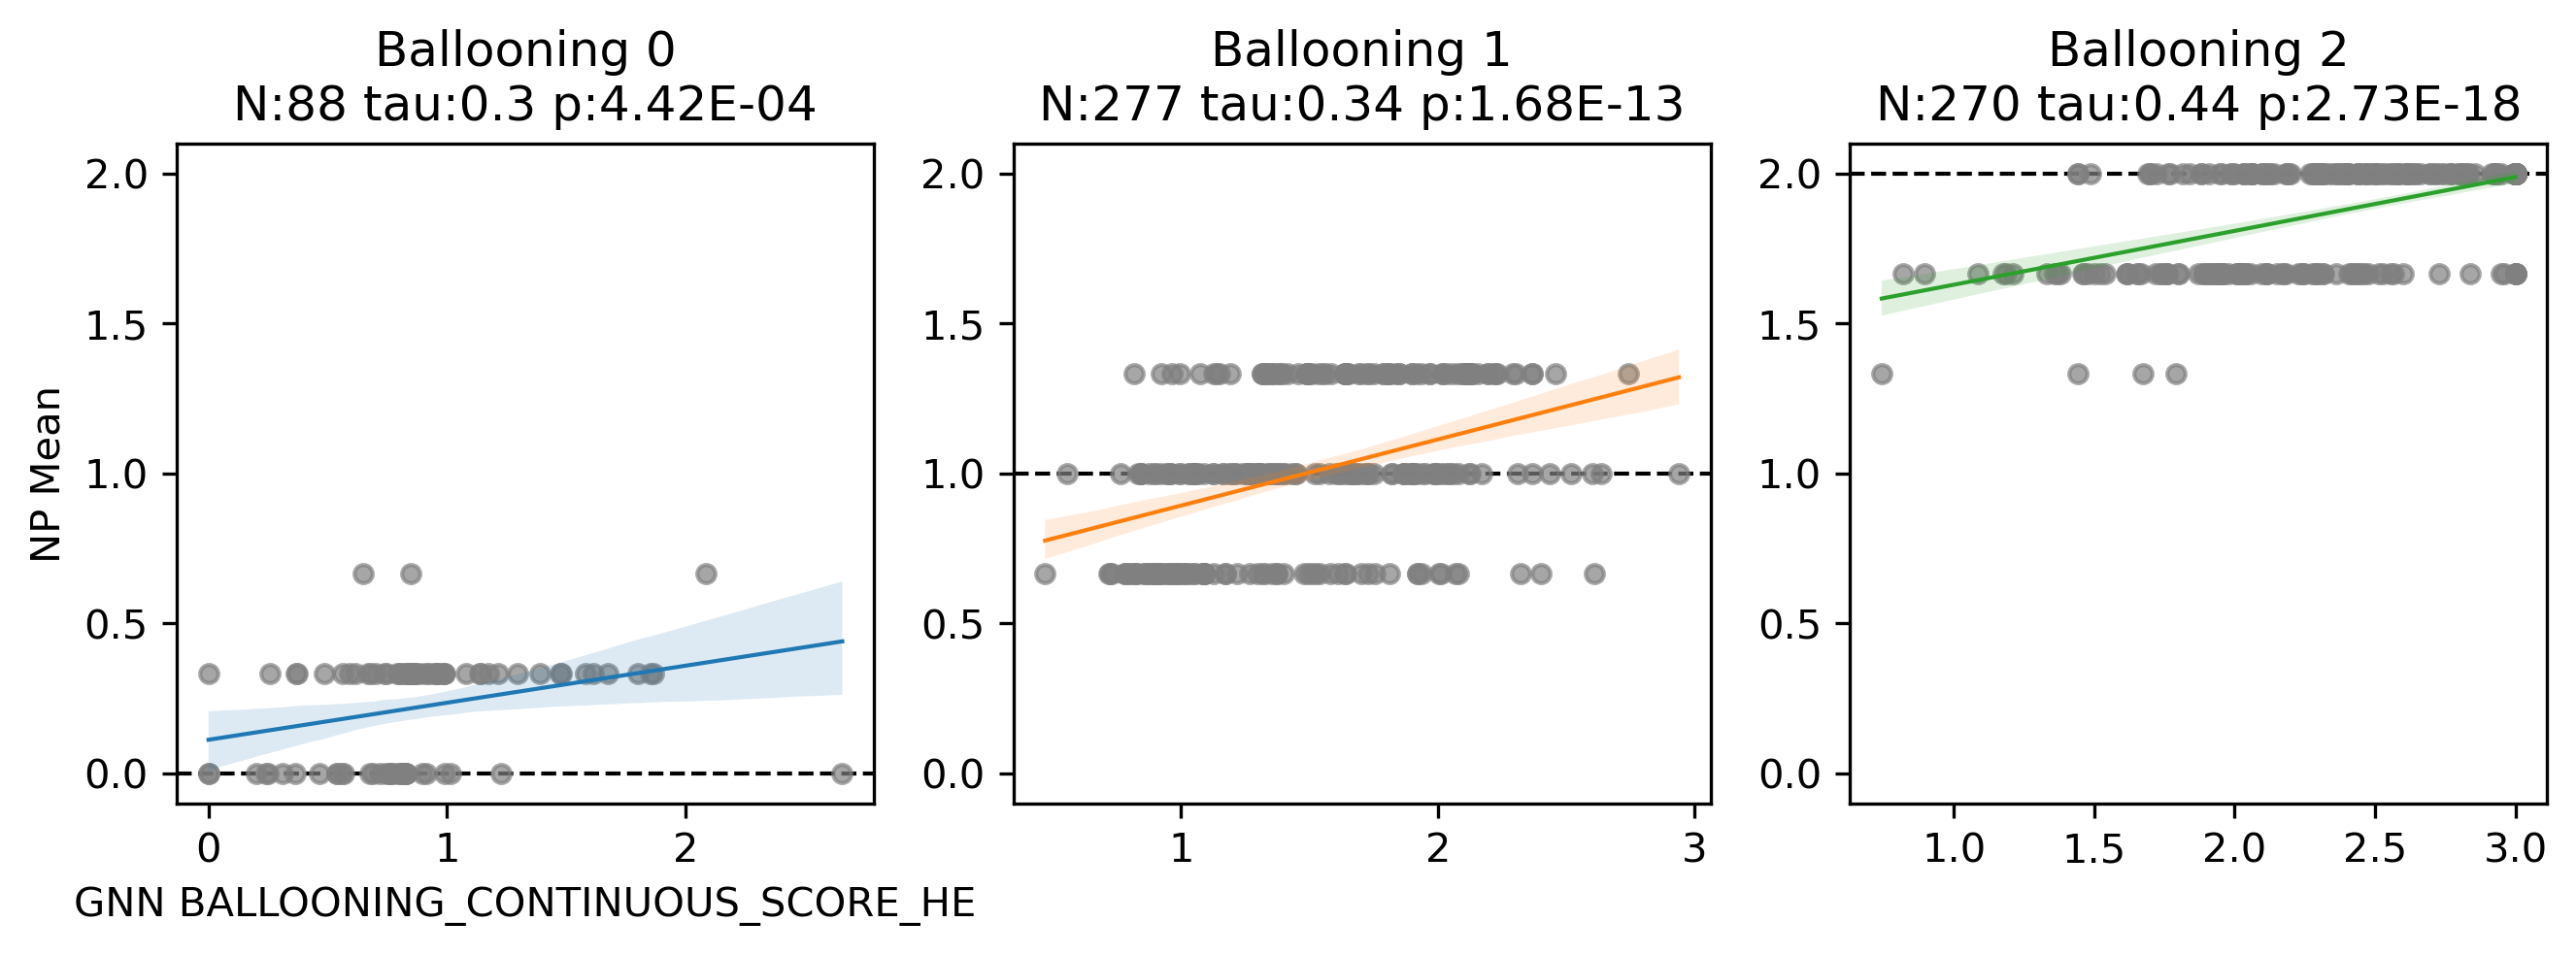

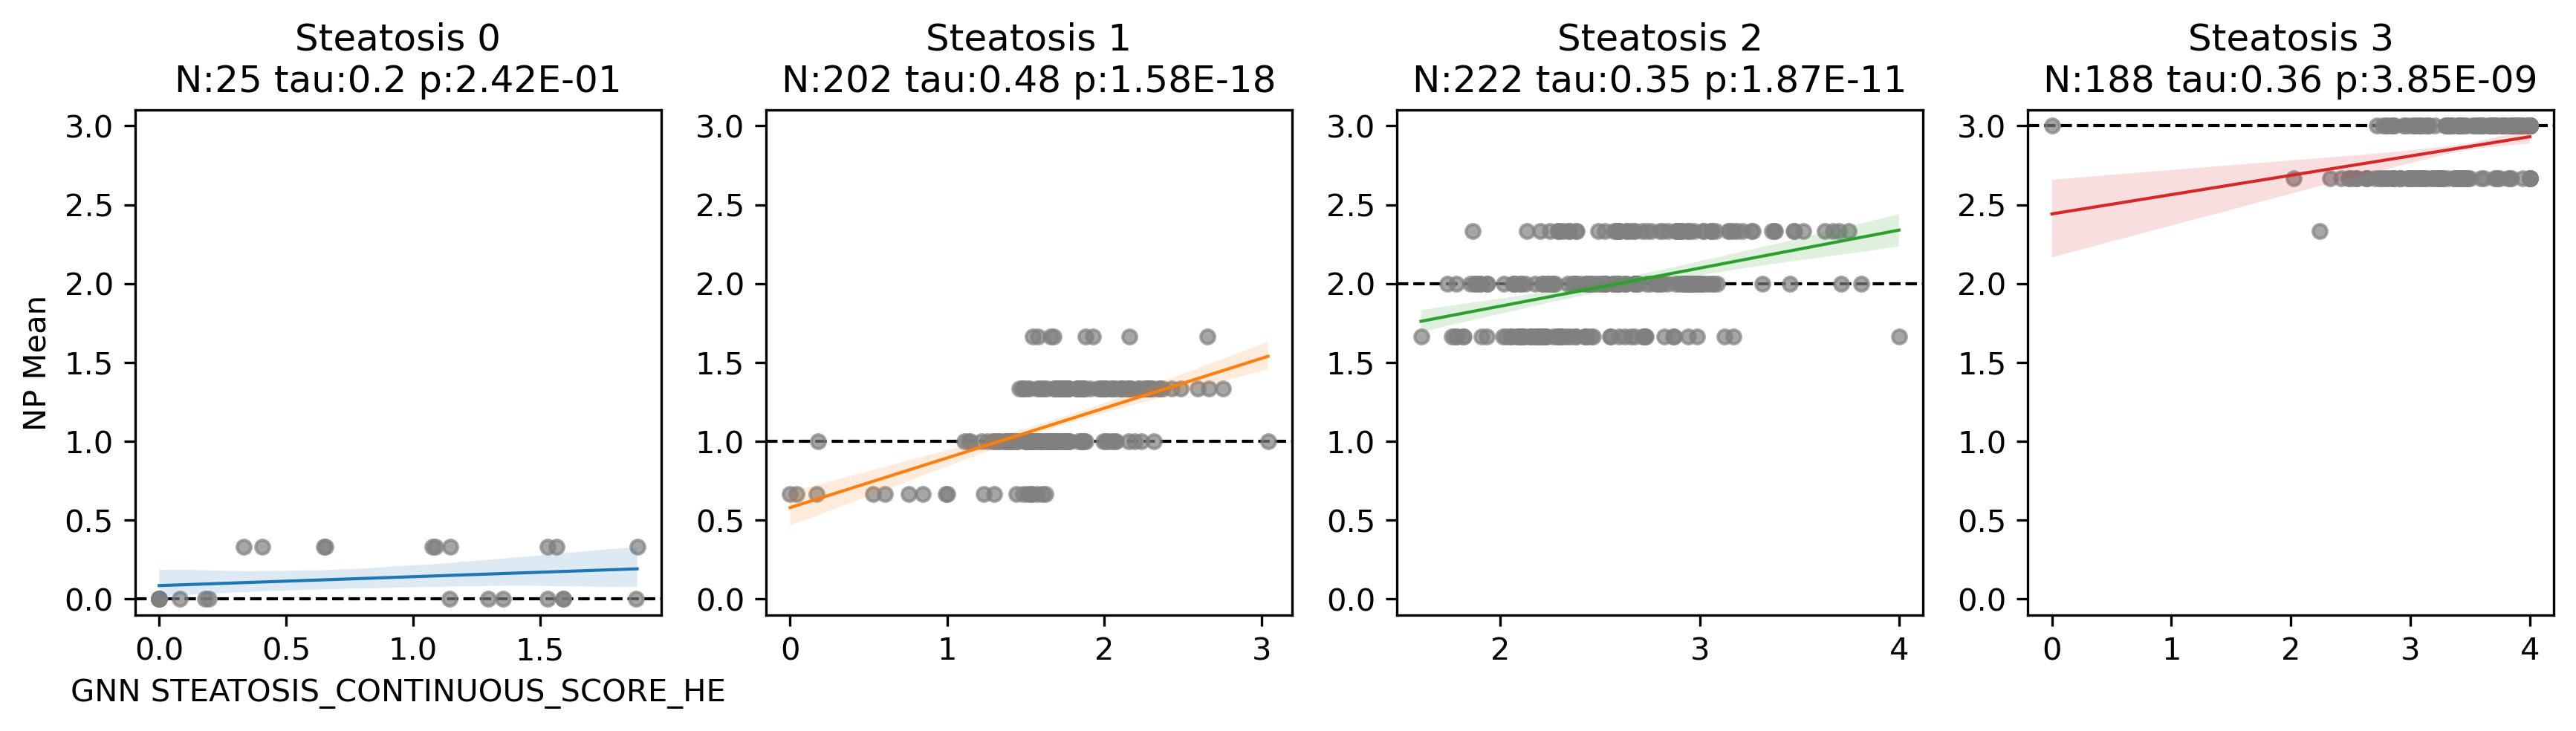

In [10]:
pal = sns.color_palette(palette='tab10',n_colors=5)
pal = pal.as_hex()
ord_max = {
    'Fibrosis':4,
    'Inflammation':3,
    'Ballooning':2,
    'Steatosis':3
}

stats_out = []

for hif, df in c_dfs.items():
    fig, axs = plt.subplots(ncols=ord_max[hif]+1)
    fig.set_size_inches(3.5 * (ord_max[hif]+1), 3)
    for f in range(ord_max[hif]+1):
        # data subset
        temp_df = df[df['AIM']==f].copy()
        
        # stats and plotting
        N = len(temp_df)
        tau, tau_p = kendalltau(temp_df[md[hif]],temp_df['NP Mean'])
        ax = sns.regplot(data = temp_df, y='NP Mean', x=md[hif], color=pal[f], ax=axs[f], scatter_kws={"color": "gray",'alpha':.7,'s':20}, line_kws={'lw':1})
        ax.axhline(f,c='0',ls='--',zorder=0,lw=1)
        ax.set_ylim([-0.1,ord_max[hif]+.1])
        ax.set_title(f'{hif} {f}\nN:{N} tau:{np.around(tau,2)} p:{tau_p:.2E}')
        if f > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
        
        # stats out
        stats_out.append({
            'Ord Score By':'AIM',
            'HIF':hif,
            'Ord Score':f,
            'Group': f"AIM {hif} {f}",
            'N':N,
            'tau':tau,
            'tau_p':tau_p
        })
        
    plt.show()
    
for hif, df in c_dfs.items():
    fig, axs = plt.subplots(ncols=ord_max[hif]+1)
    fig.set_size_inches(3.5 * (ord_max[hif]+1), 3)
    for f in range(ord_max[hif]+1):
        # data subset
        temp_df = df[df['CON']==f].copy()
        
        # stats and plotting
        N = len(temp_df)
        tau, tau_p = kendalltau(temp_df[md[hif]],temp_df['NP Mean'])
        ax = sns.regplot(data = temp_df, y='NP Mean', x=md[hif], color=pal[f], ax=axs[f], scatter_kws={"color": "gray",'alpha':.7,'s':20}, line_kws={'lw':1})
        ax.axhline(f,c='0',ls='--',zorder=0,lw=1)
        ax.set_ylim([-0.1,ord_max[hif]+.1])
        ax.set_title(f'{hif} {f}\nN:{N} tau:{np.around(tau,2)} p:{tau_p:.2E}')
        if f > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
        
        # stats out
        stats_out.append({
            'Ord Score By':'CON',
            'HIF':hif,
            'Ord Score':f,
            'Group': f"CON {hif} {f}",
            'N':N,
            'tau':tau,
            'tau_p':tau_p
        })
        
    plt.show()
    

In [11]:
stats_df = pd.DataFrame(stats_out)

In [12]:
stats_df

,Ord Score By,HIF,Ord Score,Group,N,tau,tau_p
0,AIM,Fibrosis,0,AIM Fibrosis 0,31,0.157842,2.473672e-01
1,AIM,Fibrosis,1,AIM Fibrosis 1,81,0.177986,3.116046e-02
2,AIM,Fibrosis,2,AIM Fibrosis 2,180,0.233075,1.527389e-05
3,AIM,Fibrosis,3,AIM Fibrosis 3,306,0.437133,4.292420e-25
4,AIM,Fibrosis,4,AIM Fibrosis 4,35,0.155516,2.332867e-01
5,AIM,Inflammation,0,AIM Inflammation 0,89,0.304624,1.422128e-04
6,AIM,Inflammation,1,AIM Inflammation 1,327,0.301165,4.360820e-13
7,AIM,Inflammation,2,AIM Inflammation 2,205,0.358259,6.914181e-12
8,AIM,Inflammation,3,AIM Inflammation 3,18,0.323972,9.575487e-02
9,AIM,Ballooning,0,AIM Ballooning 0,129,0.342393,1.903055e-07


In [13]:
stats_df['tau_1p'] = stats_df['tau_p']/2

sig, cor_p = fdrcorrection(stats_df[(stats_df['Ord Score By']=='AIM')  & (stats_df['tau']>0)]['tau_1p'],0.05)
stats_df.loc[(stats_df['Ord Score By']=='AIM')  & (stats_df['tau']>0),'sig'] = sig
stats_df.loc[(stats_df['Ord Score By']=='AIM')  & (stats_df['tau']>0),'q'] = cor_p

sig, cor_p = fdrcorrection(stats_df[(stats_df['Ord Score By']=='CON')  & (stats_df['tau']>0)]['tau_1p'],0.05)
stats_df.loc[(stats_df['Ord Score By']=='CON')  & (stats_df['tau']>0),'sig'] = sig
stats_df.loc[(stats_df['Ord Score By']=='CON')  & (stats_df['tau']>0),'q'] = cor_p

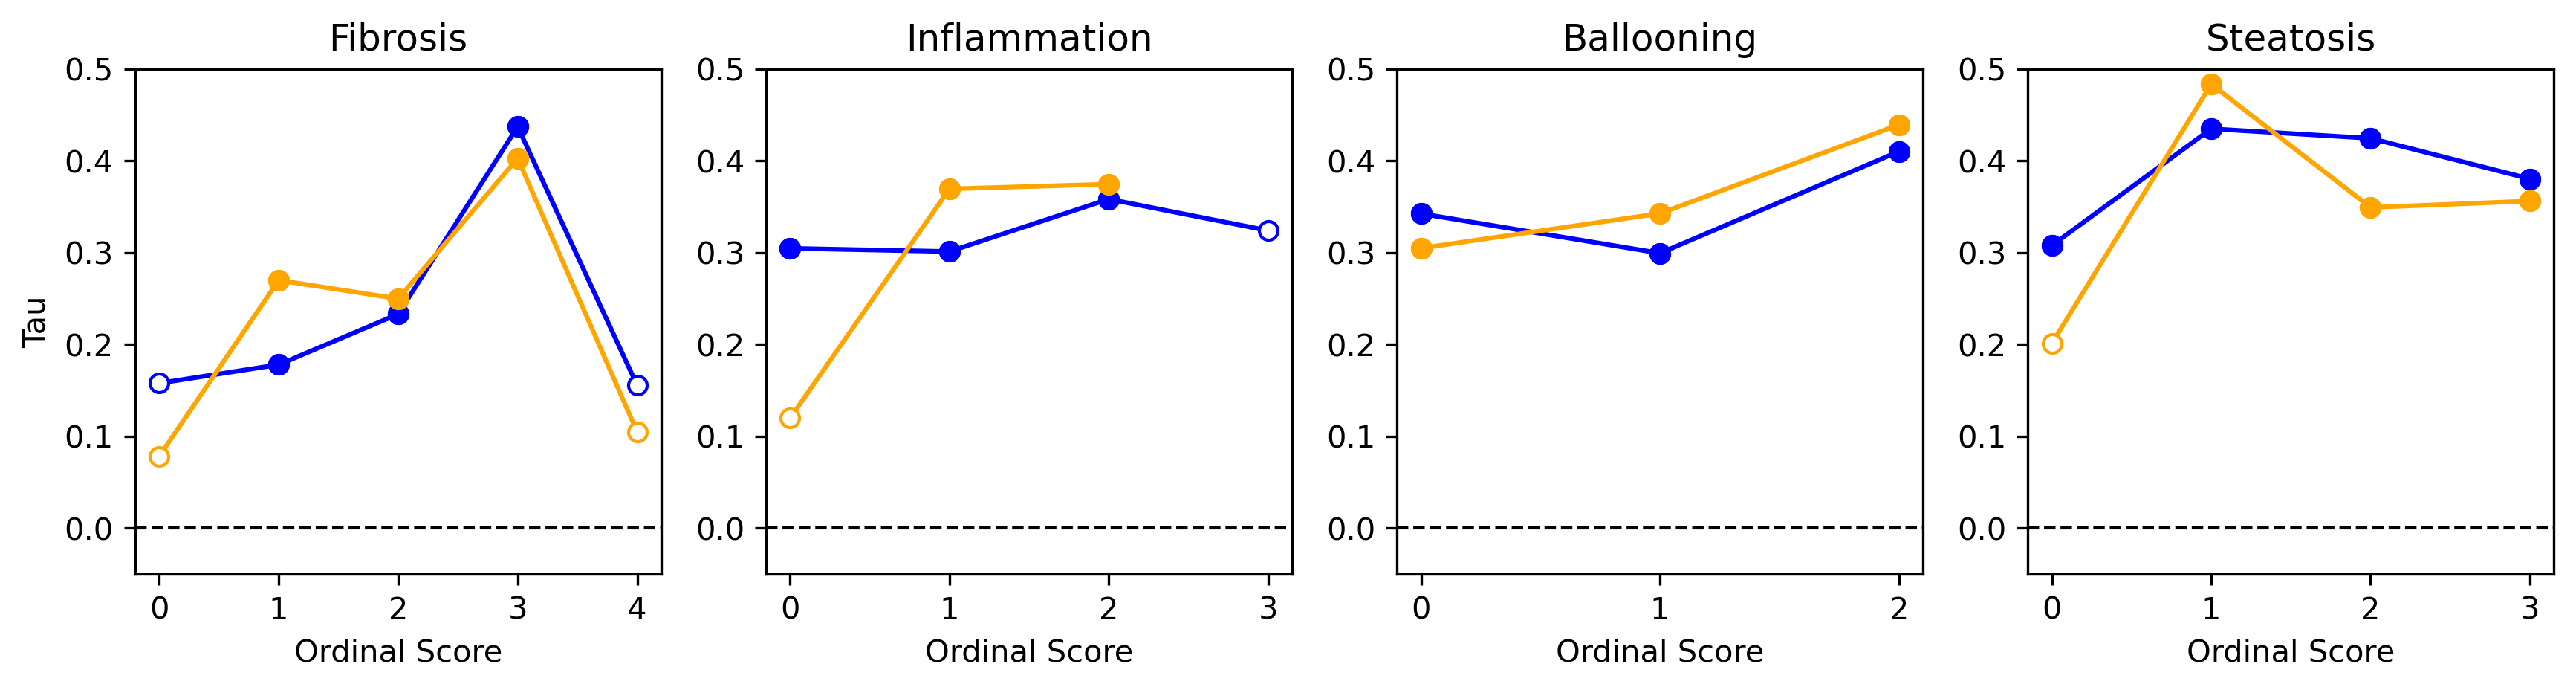

In [14]:
fig, axs = plt.subplots(ncols=4)
fig.set_size_inches(3.5 * (ord_max[hif]+1), 3)
for idx, f in enumerate(md.keys()):
    temp_df = stats_df[(stats_df['Ord Score By']=='AIM')&(stats_df['HIF']==f)].copy()
    axs[idx].plot(temp_df['Ord Score'],temp_df['tau'],marker="o", color='blue', markerfacecolor='white')
    sig_df = temp_df[temp_df['sig']==True]
    axs[idx].plot(sig_df['Ord Score'],sig_df['tau'],marker="o", color='blue', linestyle='None')
    temp_df = stats_df[(stats_df['Ord Score By']=='CON')&(stats_df['HIF']==f)].copy()
    axs[idx].plot(temp_df['Ord Score'],temp_df['tau'],marker="o", color='orange', markerfacecolor='white')
    sig_df = temp_df[temp_df['sig']==True]
    axs[idx].plot(sig_df['Ord Score'],sig_df['tau'],marker="o", color='orange',linestyle = 'None')
    axs[idx].set_ylim([-.05,0.5])
    axs[idx].axhline(0,c='0',ls='--',zorder=0,lw=1)
    axs[idx].set_title(f)
    axs[idx].set_xticks(range(ord_max[f]+1))
    axs[idx].set_xlabel('Ordinal Score')
    
    if idx==0:
        axs[idx].set_ylabel('Tau')
    
plt.show()

In [19]:
fig.savefig('OUTPUTS/tau_summary_fig.png',dpi=300, bbox_inches='tight')